# Create Hydrographs of Streamflow

## Description

The NOAA National Water Model Retrospective [dataset](https://registry.opendata.aws/nwm-archive/) is an open AWS dataset. It contains input and output from multi-decade CONUS retrospective simulations. 

CONUS Version 3.0 - A 44-year (February 1979 through January 2023) retrospective simulation using version 3.0 of the National Water Model. This is hourly data. This notebook looks at the streamflow data.

The mean calculations take >2Gb of RAM so make sure to pick at 4Gb instance not the 2Gb default.


## Load in the Zarr file on AWS

Step one is to load in the Zarr file so we have all the data (lazily).

In [2]:
import xarray as xr
import fsspec

# Set storage options for anonymous S3 access
so = {
    "anon": True,
    "client_kwargs": {"region_name": "us-east-1"}
}

Now that we have specified the S3 access, we can load in the Zarr file lazily (just the metadata). The streamflow alone is 4.5 Tb.

In [3]:
# Path to the Zarr store
zarr_path = "s3://noaa-nwm-retrospective-3-0-pds/CONUS/zarr/chrtout.zarr"

# Open the Zarr dataset using xarray
ds = xr.open_zarr(zarr_path, storage_options=so, consolidated=True)

In [55]:
# Peek at the dataset
ds["streamflow"]

<xarray.DataArray 'streamflow' (time: 385704, feature_id: 2776734)> Size: 9TB
dask.array<open_dataset-streamflow, shape=(385704, 2776734), dtype=float64, chunksize=(672, 30000), chunktype=numpy.ndarray>
Coordinates:
    elevation   (feature_id) float32 11MB dask.array<chunksize=(2776734,), meta=np.ndarray>
  * feature_id  (feature_id) int64 22MB 101 179 181 ... 1180001803 1180001804
    gage_id     (feature_id) |S15 42MB dask.array<chunksize=(2776734,), meta=np.ndarray>
    latitude    (feature_id) float32 11MB dask.array<chunksize=(2776734,), meta=np.ndarray>
    longitude   (feature_id) float32 11MB dask.array<chunksize=(2776734,), meta=np.ndarray>
    order       (feature_id) int32 11MB dask.array<chunksize=(2776734,), meta=np.ndarray>
  * time        (time) datetime64[ns] 3MB 1979-02-01T01:00:00 ... 2023-02-01
Attributes:
    grid_mapping:  crs
    long_name:     River Flow
    units:         m3 s-1

## Load in the feature_ids and subset ds

The feature ids were created in the file `load_feature_ids.ipynb`. Here I will load in the data frame and subset `ds` to just those.

In [4]:
import pandas as pd

# Load the full CSV
df = pd.read_csv("wr18_comids.csv")

# Filter where FTYPE is exactly "StreamRiver"
streamriver_df = df[df["FTYPE"] == "StreamRiver"]

# Extract COMIDs (aka feature_ids)
feature_ids = streamriver_df["COMID"].unique()

len(feature_ids)

108330

In [5]:
# make sure feature_ids in the file are in the Zarr file
available_ids = ds.feature_id.values

# Convert your list to a NumPy array
import numpy as np
feature_ids = np.array(feature_ids, dtype=int)

# Find the intersection (only those that exist in the dataset)
valid_ids = np.intersect1d(feature_ids, available_ids)

print(f"{len(valid_ids)} of {len(feature_ids)} feature_ids matched the dataset.")

102215 of 108330 feature_ids matched the dataset.


In [6]:
# Subset the dataset and just get streamflow
subset_ds = ds["streamflow"].sel(feature_id=valid_ids)

In [66]:
subset_ds

<xarray.DataArray 'streamflow' (time: 385704, feature_id: 102215)> Size: 315GB
dask.array<getitem, shape=(385704, 102215), dtype=float64, chunksize=(672, 29857), chunktype=numpy.ndarray>
Coordinates:
    elevation   (feature_id) float32 409kB dask.array<chunksize=(102215,), meta=np.ndarray>
  * feature_id  (feature_id) int64 818kB 341095 341097 ... 948070587 948090493
    gage_id     (feature_id) |S15 2MB dask.array<chunksize=(102215,), meta=np.ndarray>
    latitude    (feature_id) float32 409kB dask.array<chunksize=(102215,), meta=np.ndarray>
    longitude   (feature_id) float32 409kB dask.array<chunksize=(102215,), meta=np.ndarray>
    order       (feature_id) int32 409kB dask.array<chunksize=(102215,), meta=np.ndarray>
  * time        (time) datetime64[ns] 3MB 1979-02-01T01:00:00 ... 2023-02-01
Attributes:
    grid_mapping:  crs
    long_name:     River Flow
    units:         m3 s-1

## Make a hydrograph

In [28]:
# Select feature and year

fid = subset_ds.feature_id.values[1]
year = "2022"

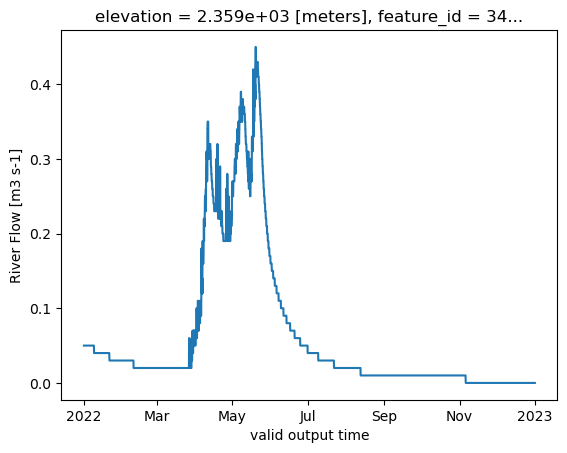

In [26]:
streamflow_ts = subset_ds.sel(feature_id=fid, time=year)
streamflow_ts.plot();

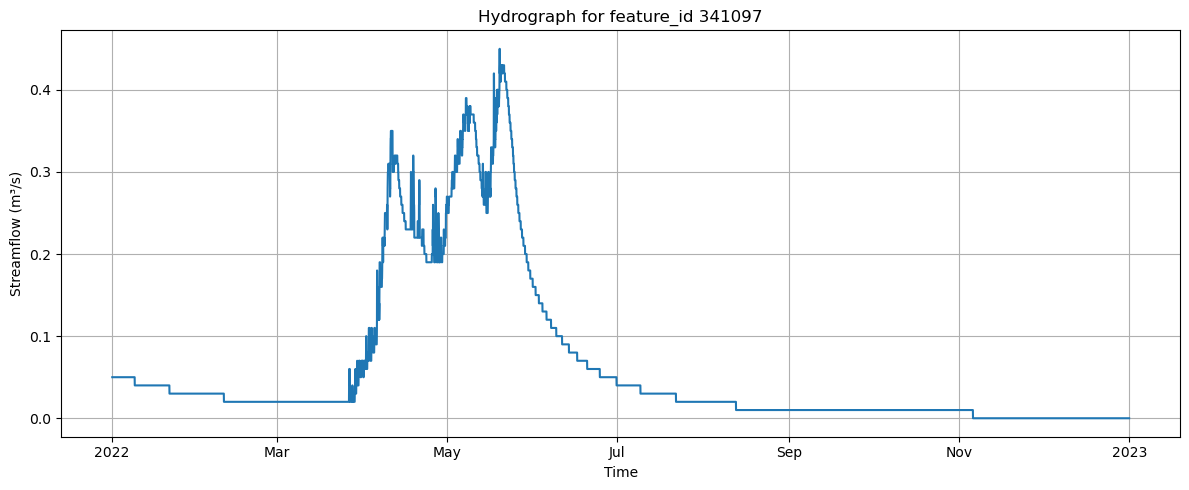

In [21]:
# prettier
import matplotlib.pyplot as plt

# Plot the time series
plt.figure(figsize=(12, 5))
streamflow_ts.plot()
plt.title(f"Hydrograph for feature_id {fid}")
plt.xlabel("Time")
plt.ylabel("Streamflow (m³/s)")
plt.grid(True)
plt.tight_layout()
plt.show()


## Let's compute the daily mean for a feature_id

For one year. 

In [15]:
%%time
streamflow_ts = subset_ds.isel(feature_id=1).sel(time="2022").load()
daily_mean = streamflow_ts.resample(time="1D").mean()

CPU times: user 44.8 s, sys: 22 s, total: 1min 6s
Wall time: 36.8 s


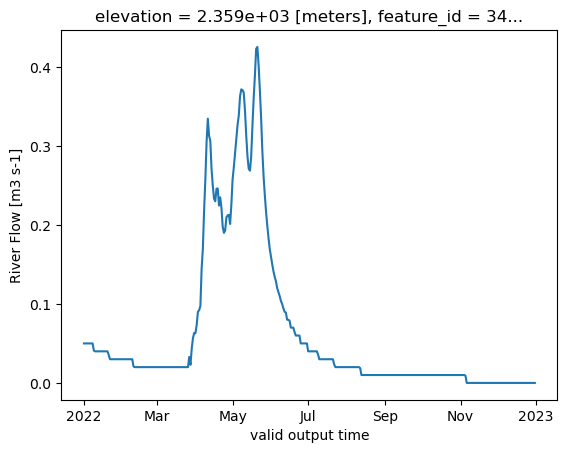

In [16]:
daily_mean.plot();

## Save the daily means

### One year, csv

Let's save one year and one feature id to a csv. This is not very efficient. Fine for one year and one feature id but terrible if the goal is to do 100k feature ids.

In [36]:
filename = f"daily_mean_streamflow_fid{fid}_{year}.csv"
daily_mean.to_series().to_frame(name="streamflow").to_csv(filename, index=True)
print(f"Saved to {filename}")

Saved to daily_mean_streamflow_fid341097_2022.csv
CPU times: user 2.64 ms, sys: 125 µs, total: 2.77 ms
Wall time: 5.56 ms


## All years, save to netcdf

Doing just one feature id is very inefficient as the bottleneck here in the IO step (getting data from S3) and that pulls in all feature ids. Let's do all feature ids for each year and save to netcdf. Note that xarray uses dask under the hood in the `.compute()` step and since our data is chunked (look at `print(subset_ds.chunks)`), dask will nicely do the computation in chunks that will not max out our RAM. I am using 7Gb RAM instance and this maxes out at about 3 Gb RAM.

First let's try doing all years to see how long each year takes. It takes about 1.75 minutes. So 44 years will take 77 minutes. Not too bad.

In [7]:
%%time
streamflow_ts = subset_ds.sel(time="2018")

# Resample daily mean, preserving the feature_id dimension
daily_mean = streamflow_ts.resample(time="1D").mean().compute()

CPU times: user 2min 7s, sys: 59.5 s, total: 3min 7s
Wall time: 1min 45s


### Simple approach no chunking (bad idea)

We could do this but the files would be much bigger than necessary and when we wanted to use them in the cloud we would have to load the whole file. Ack.

In [9]:
for year in range(1979, 2023):  # NWM 3.0 range
    print(f"Processing {year}...")
    
    # Subset 1 year
    year_ts = subset_ds.sel(time=str(year))

    # Resample daily mean
    daily_mean = year_ts.resample(time="1D").mean().compute()

    # Save as netcdf
    daily_mean.to_netcdf(f"daily_mean_{year}.nc")

Processing 1979...
Processing 1980...
Processing 1981...
Processing 1982...
Processing 1983...
Processing 1984...
Processing 1985...
Processing 1986...
Processing 1987...
Processing 1988...
Processing 1989...
Processing 1990...
Processing 1991...
Processing 1992...
Processing 1993...
Processing 1994...
Processing 1995...
Processing 1996...
Processing 1997...
Processing 1998...
Processing 1999...
Processing 2000...
Processing 2001...
Processing 2002...
Processing 2003...
Processing 2004...
Processing 2005...
Processing 2006...
Processing 2007...
Processing 2008...
Processing 2009...
Processing 2010...
Processing 2011...
Processing 2012...
Processing 2013...
Processing 2014...
Processing 2015...
Processing 2016...
Processing 2017...
Processing 2018...
Processing 2019...
Processing 2020...
Processing 2021...
Processing 2022...


### Much better approach. Chunk the data.

All our great `xarray` and `dask` parallel tooling requires that our datasets are chunked. Let's do that from the get go. We will also compress which will make our files much smaller (90 Mb versus 300 Mb).

In [ ]:
for year in range(1979, 2024):  # NWM 3.0 range is 1979 to 2023
    print(f"🔄 Processing {year}...")
    
    # Subset 1 year
    year_ts = subset_ds.sel(time=str(year))

    # Resample daily mean and compute
    daily_mean = year_ts.resample(time="1D").mean().compute()

    # Get correct chunk sizes based on dim order (likely time, feature_id)
    time_chunk = daily_mean.sizes["time"]
    feature_chunk = min(5000, daily_mean.sizes["feature_id"])

    # Apply chunking in memory (optional but helpful for clarity)
    daily_mean = daily_mean.chunk({"feature_id": feature_chunk})

    # Set encoding
    encoding = {
        "streamflow": {
            "chunksizes": (time_chunk, feature_chunk),  # match (time, feature_id)
            "zlib": True,
            "complevel": 4
        }
    }

    # Save with compression and chunking
    out_path = f"daily_mean_{year}.nc"
    daily_mean.to_netcdf(out_path, encoding=encoding, engine="netcdf4")

    print(f"✅ Saved {out_path}")


## Summary

We saved the daily means as netcdf files. Unfortunately, I did not chunk them and that will make them inefficient. 

Go to the `save_to_gcp.ipynb` notebook to see how to upload these to GCP.